# Analysis for autoregressive Modelling

In [1]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
#https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
#https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [36]:
import data_prep_helper
from statsmodels.tsa.vector_ar.var_model import VAR
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plot_helper as ph

In [61]:
do = data_prep_helper.ChartData()
do.apply_boll_bands("bitcoin_hist", append_chart=True)

In [62]:
corr_df = do.chart_df

In [63]:
cols = corr_df.columns

## Check On Seasonality

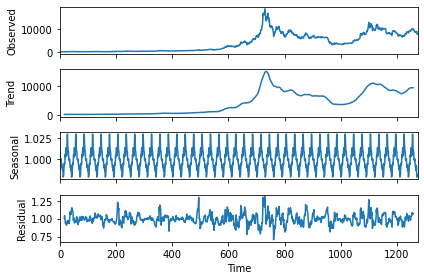

In [64]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
# Input dataframe df has prices under the column name 'close'

series = pd.DataFrame(data=corr_df['bitcoin_Price'].values, index=pd.to_datetime(corr_df.index), columns = ['bitcoin_Price']).dropna()
result = seasonal_decompose(series.values, model='multiplicative', freq=30)
result.plot()
pyplot.show()

## Check on Stationarity

### AdFuller Test

In [65]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(corr_df['bitcoin_Price'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.657399
p-value                           0.453185
#Lags Used                        3.000000
Number of Observations Used    1270.000000
Critical Value (1%)              -3.435510
Critical Value (5%)              -2.863818
Critical Value (10%)             -2.567983
dtype: float64


As the p-value is much higher than default significance level of 0.05 we have a strong indicator for confirming the null hypothesis that the time series isn't stationary.

In [66]:
def check_adf_sign(timeseries, name='', sign=0.05):
    dftest = adfuller(timeseries, autolag='AIC')
    p_val = round(dftest[1], 4)
    
    if p_val >= sign:
        print("{} isn't stationary.".format(name))
    else:
        print("{} is stationary.".format(name))


In [67]:
for name, col in corr_df.iteritems():
    check_adf_sign(col, name)

bitcoin_Price isn't stationary.
sp500_Price isn't stationary.
dax_Price isn't stationary.
googl_Price isn't stationary.
gold_Price isn't stationary.
bitcoin_Google_Trends isn't stationary.
cryptocurrency_Google_Trends isn't stationary.
trading_Google_Trends is stationary.
bitcoin_pos_sents is stationary.
bitcoin_neg_sents isn't stationary.
bitcoin_quot_sents is stationary.
economy_pos_sents isn't stationary.
economy_neg_sents is stationary.
economy_quot_sents is stationary.
bitcoin_30_day_ma isn't stationary.
bitcoin_30_day_std isn't stationary.
bitcoin_boll_upp isn't stationary.
bitcoin_boll_low isn't stationary.


In [68]:
corr_df = corr_df.diff().dropna()

In [69]:
for name, col in corr_df.iteritems():
    check_adf_sign(col, name)

bitcoin_Price is stationary.
sp500_Price is stationary.
dax_Price is stationary.
googl_Price is stationary.
gold_Price is stationary.
bitcoin_Google_Trends is stationary.
cryptocurrency_Google_Trends is stationary.
trading_Google_Trends is stationary.
bitcoin_pos_sents is stationary.
bitcoin_neg_sents is stationary.
bitcoin_quot_sents is stationary.
economy_pos_sents is stationary.
economy_neg_sents is stationary.
economy_quot_sents is stationary.
bitcoin_30_day_ma is stationary.
bitcoin_30_day_std is stationary.
bitcoin_boll_upp is stationary.
bitcoin_boll_low is stationary.


## Check on Causalisation between Time Series

  * Explanation of Difference Correlation and Causalisation: https://calculatedcontent.com/2013/05/27/causation-vs-correlation-granger-causality/
  * Used Function from: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/


In [70]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=30
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

gcm_df = grangers_causation_matrix(corr_df, variables = corr_df.columns)        

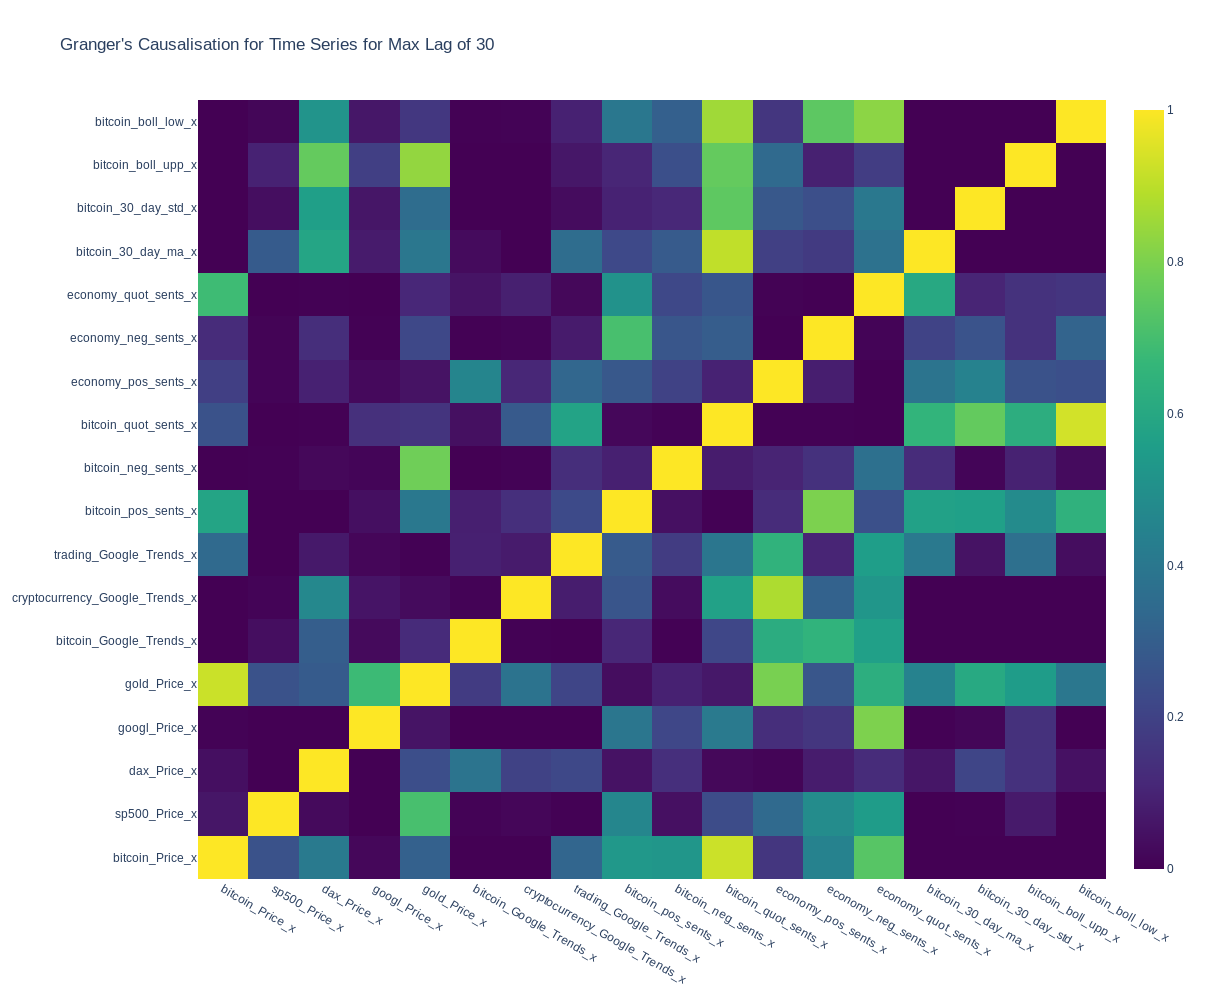

In [71]:
ph.plot_val_heatmap(gcm_df, "Granger's Causalisation for Time Series for Max Lag of {}".format(str(maxlag)))

This variables seems to have a strong causalisation on Bitcoin Price for a lag of 30 days:
  * Google Price
  * Bitcoin Google Trends
  * Cryptocurrency Google Trends
  